# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify all symbols

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [3]:
pip install --upgrade pip

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.1 MB 1.2 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/2.1 MB 3.0 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/2.1 MB 5.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.3/2.1 MB 6.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.7/2.1 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install required packages (once per virtual environment)
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost

  Using cached scikit_learn-1.4.0-1-cp312-cp312-win_amd64.whl.metadata (11 kB)
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.4 kB 487.6 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 456.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
    --------------------------------------- 0.2/10.6 MB 3.3 MB/s eta 0:00:04
   - -------------------------------------- 0.5/10.6 MB 5.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/10.6 MB 6.6 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/10.6 MB 7.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.6 MB 8.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/10.6 MB 8.3 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/10.6 MB 8.4 MB/s eta 0:00:01
   ----

In [110]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
'''
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
'''
# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings

In [102]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    '''
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)
    '''

In [4]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
test = pd.DataFrame()
test['image'] = list(image)
test['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
test['label'] = label
test['class'] = class_label

In [68]:
train_subset = train.sample(n=10000, replace=False, random_state=42)

In [69]:
# データセットの特徴量とラベルを準備
X = train_subset.drop('label',axis=1)  # 特徴量
y = train_subset.label  # ラベル

# 層化サンプリングでデータセットを分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,  # テストデータセットの割合
    random_state=42,  # 再現性のための乱数シード
    stratify=y  # 層化サンプリングを行うためのラベル指定
)

# 分割後のデータセットのサイズを確認
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 7000
Test set size: 3000


In [70]:
# All symbols classifier: XGBoost
task = 'All_symbols'
model_name = 'xgboost'

# Initializa XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate the model
xgb_clf.fit(X_train['image_flat'].tolist(),y_train)
y_pred = xgb_clf.predict(X_test['image_flat'].tolist())



In [81]:
metrics_dict = {
    'All_symbols': {  # タスク名
        'xgboost': {  # モデル名
            'accuracy': [],  # 精度を格納するリスト
            'precision': [],  # 適合率を格納するリスト
            'recall': [],  # 再現率を格納するリスト
            'f1': []  # F1スコアを格納するリスト
        }
    }
}

In [75]:
# Calculate performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred,average='weighted',zero_division=0)
rec = recall_score(y_test, y_pred,average='weighted',zero_division=0)
f1 = f1_score(y_test, y_pred,average='weighted',zero_division=0)
cm = confusion_matrix(y_test, y_pred)



In [82]:
# Store performance metrics in dictionary
metrics_dict['All_symbols']['xgboost']['accuracy'].append(acc)
metrics_dict['All_symbols']['xgboost']['precision'].append(prec)
metrics_dict['All_symbols']['xgboost']['recall'].append(rec)
metrics_dict['All_symbols']['xgboost']['f1'].append(f1)

In [83]:
metrics_dict

{'All_symbols': {'xgboost': {'accuracy': [0.6626666666666666],
   'precision': [0.6415090223702722],
   'recall': [0.6626666666666666],
   'f1': [0.6466829409969839]}}}

In [86]:
# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,[0.6626666666666666],[0.6415090223702722],[0.6626666666666666],[0.6466829409969839]


# Confusion Matrix: xgboost

""


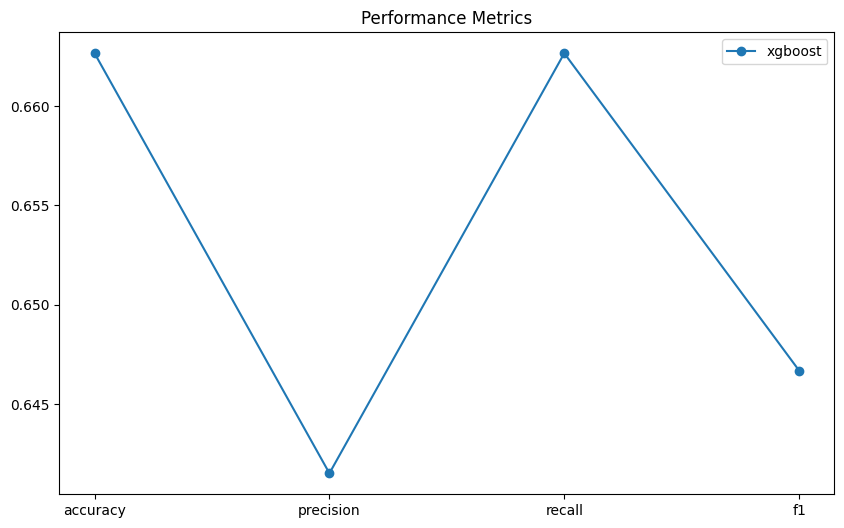

In [87]:
# Visualise the performance
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['All_symbols'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['All_symbols'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics')

# show the plot
plt.show()

In [91]:
# Investigate subsets
# Make subsets
## O and 0
symbols_list = ['O', '0']
mask_valid = X_test['class'].apply(lambda x: x in symbols_list)
valid_01_X = X_test[mask_valid]
valid_01_y = y_test[mask_valid]
valid_01_X.reset_index(drop=True, inplace=True)
valid_01_y.reset_index(drop=True, inplace=True)
## l and 1
symbols_list = ['l', '1']
mask_valid = X_test['class'].apply(lambda x: x in symbols_list)
valid_02_X = X_test[mask_valid]
valid_02_y = y_test[mask_valid]
valid_02_X.reset_index(drop=True, inplace=True)
valid_02_y.reset_index(drop=True, inplace=True)
## Z and 2
symbols_list = ['Z', '2']
mask_valid = X_test['class'].apply(lambda x: x in symbols_list)
valid_03_X = X_test[mask_valid]
valid_03_y = y_test[mask_valid]
valid_03_X.reset_index(drop=True, inplace=True)
valid_03_y.reset_index(drop=True, inplace=True)


In [104]:
metrics_dict_subsets = {
    'Investigate_subsets_using_xgboost' : { # task name (Investigate_subsets_using_xgboost)
        'O vs 0': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'l vs 1': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'Z vs 2': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [105]:
metrics_dict_subsets

{'Investigate_subsets_using_xgboost': {'O vs 0': {'accuracy': [],
   'precision': [],
   'recall': [],
   'f1': []},
  'l vs 1': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
  'Z vs 2': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}}}

In [107]:
# All symbols classifier: XGBoost
task = 'Investigate_subsets_using_xgboost'

y_pred_01 = xgb_clf.predict(valid_01['image_flat'].tolist())
y_pred_02 = xgb_clf.predict(valid_02['image_flat'].tolist())
y_pred_03 = xgb_clf.predict(valid_03['image_flat'].tolist())

# O vs 0
## Calculate performance metrics
model_name = 'O vs 0'
acc = accuracy_score(valid_01_y, y_pred_01)
prec = precision_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
rec = recall_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
f1 = f1_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)

## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }
# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

# l vs 1
## Calculate performance metrics
model_name = 'l vs 1'
acc = accuracy_score(valid_02_y, y_pred_02)
prec = precision_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)
rec = recall_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)
f1 = f1_score(valid_02_y, y_pred_02,average='weighted',zero_division=0)

## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }
# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

# Z vs 2
## Calculate performance metrics
model_name = 'Z vs 2'
acc = accuracy_score(valid_03_y, y_pred_03)
prec = precision_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)
rec = recall_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)
f1 = f1_score(valid_03_y, y_pred_03,average='weighted',zero_division=0)

## Store performance metrics in dictionary
metrics_dict_subsets[task][model_name] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

# Performance Metrics: O vs 0

,accuracy,precision,recall,f1
0,0.552632,0.602824,0.552632,0.576009


# Performance Metrics: l vs 1

,accuracy,precision,recall,f1
0,0.66087,0.741914,0.66087,0.690201


# Performance Metrics: Z vs 2

,accuracy,precision,recall,f1
0,0.748344,0.896897,0.748344,0.812268


In [166]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}


In [167]:
 X_test = X_test['image_flat'].tolist()

In [168]:
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

In [170]:
grid_search.fit(X_test, y_test)

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"最適パラメータ: {best_params}")
print(f"最高スコア: {best_score}")


最適パラメータ: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
最高スコア: 0.8029164410176381


In [ ]:
y_pred = winning_mdl.predict(valid['image_flat'].tolist())

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred,average='weighted',zero_division=0)
rec = recall_score(y_test, y_pred,average='weighted',zero_division=0)
f1 = f1_score(y_test, y_pred,average='weighted',zero_division=0)

In [ ]:
metrics_dict_subsets = {
    'All symbols': {  # タスク名
        'xgboost_winning': {  # モデル名
            'accuracy': [],  # 精度を格納するリスト
            'precision': [],  # 適合率を格納するリスト
            'recall': [],  # 再現率を格納するリスト
            'f1': []  # F1スコアを格納するリスト
        }
    }
}

In [ ]:
## Store performance metrics in dictionary
task = 'All symbols'
model_name = 'xgboost_winning'
metrics_dict_subsets['digit or letters']['xgboost_winning'] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

# Performance Metrics: xgboost_winning

,accuracy,precision,recall,f1
0,0.851921,0.852159,0.851921,0.851905


## 2. Classify digits vs. letters model showdown

Perform a full showdown classifying digits vs letters:

1. Create a column for whether each row is a digit or a letter
2. Choose an evaluation metric 
3. Choose several candidate models to train
4. Divide data to reserve a validation set that will NOT be used in training/testing
5. K-fold train/test
    1. Create train/test splits from the non-validation dataset 
    2. Train each candidate model (best practice: use the same split for all models)
    3. Apply the model the the test split 
    4. (*Optional*) Perform hyper-parametric search
    5. Record the model evaluation metrics
    6. Repeat with a new train/test split
6. Promote winner, apply model to validation set
7. (*Optional*) Perform hyper-parametric search, if applicable
8. Report model performance

In [147]:
# 1. Create a column for whether each row is a digit or a letter
def recategorize(label):
    if str(label).isdigit() and 0 <= int(label) <= 9:
        return 0
    else:
        return 1

train['recategory'] = train['label'].apply(recategorize)
valid['recategory'] = valid['label'].apply(recategorize)
train_subset['recategory'] = train_subset['label'].apply(recategorize)

In [ ]:
def classify_label(x):
    if x in range(10):
        return 'numbers'
    elif x in range(10, 62):
        return 'letters'
    else:
        return None

In [ ]:
# 2. Choose an evaluation metric 
## F1

In [ ]:
# 3. Choose several candidate models to train
## Logistic Regression and XGBoost

In [ ]:
# 4. Divide data to reserve a validation set that will NOT be used in training/testing
## 'valid' is the validation set

In [148]:
# 5. K-fold train/test
cv = KFold(n_splits=5, shuffle=True, random_state= 42)


scores  = []
test_label = train_subset['recategory']

for train_index, test_index in cv.split(train_subset):
    X_train2, X_test2 = train_subset.iloc[train_index], train_subset.iloc[test_index]
    y_train2, y_test2 = test_label.iloc[train_index],test_label.iloc[test_index]
    X_train2 = X_train2['image_flat'].tolist()
    X_test2 = X_test2['image_flat'].tolist()
    
    xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
    
    # モデルの訓練
    xgb_clf.fit(X_train2, y_train2)
    
    # テストデータでモデルを評価
    y_pred = xgb_clf.predict(X_test2)
    score = f1_score(y_test2, y_pred,average='macro')
    scores.append(score)

# 全フォールドの平均スコアを計算
average_score = np.mean(scores)
print(f"平均スコア: {average_score}")

平均スコア: 0.831880334418518


In [152]:
for train_index, test_index in cv.split(X):
    X_train2, X_test2 = train_subset.iloc[train_index], train_subset.iloc[test_index]
    y_train2, y_test2 = test_label.iloc[train_index],test_label.iloc[test_index]

    scaler = StandardScaler()
    X_train2_scaled = scaler.fit_transform(X_train2['image_flat'].tolist())
    X_test2_scaled = scaler.transform(X_test2['image_flat'].tolist())

# Initialize logistic regression classifier
    lr_clf = LogisticRegression(max_iter=1000, random_state=42)

    # モデルの訓練
    lr_clf.fit(X_train2_scaled, y_train2)
    
    # テストデータでモデルを評価
    y_pred = lr_clf.predict(X_test2_scaled)
    score = f1_score(y_test2, y_pred,average='macro')
    scores.append(score)

# 全フォールドの平均スコアを計算
average_score = np.mean(scores)
print(f"平均スコア: {average_score}")

平均スコア: 0.7686590784255384


In [ ]:
##4. (*Optional*) Perform hyper-parametric search
## XGBoost




##5. Record the model evaluation metrics
##6. Repeat with a new train/test split

In [153]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}

In [154]:
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

In [155]:
grid_search.fit(X_test2['image_flat'].tolist(), y_test2)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='f1')

In [156]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"最適パラメータ: {best_params}")
print(f"最高スコア: {best_score}")


最適パラメータ: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
最高スコア: 0.8029164410176381


In [158]:
# チューニング対象のパラメータ
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Cの値の範囲
    'penalty': ['l1', 'l2']  # L1正則化とL2正則化
}

# GridSearchCVの初期化
grid_search = GridSearchCV(lr_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)


# グリッドサーチの実行
grid_search.fit(X_test2['image_flat'].tolist(), y_test2)

# 最適なパラメータとスコアの表示
print("最適なパラメータ:", grid_search.best_params_)
print("最高のスコア:", grid_search.best_score_)

c:\Users\ykatsuhara\Desktop\datasci_223\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ykatsuhara\Desktop\datasci_223\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ykatsuhara\Desktop\datasci_223\.venv\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ykatsuhara\Desktop\datasci_223\.venv

最適なパラメータ: {'C': 0.0001, 'penalty': 'l2'}
最高のスコア: 0.687407556630877


c:\Users\ykatsuhara\Desktop\datasci_223\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#6. Promote winner, apply model to validation set

In [159]:
winning_mdl = XGBClassifier(learning_rate= 0.1, max_depth= 5, min_child_weight= 1, n_estimators= 100, subsample= 0.8)
winning_mdl.fit(valid['image_flat'].tolist(), valid['recategory'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [160]:
y_pred = winning_mdl.predict(valid['image_flat'].tolist())

In [161]:
acc = accuracy_score(valid['recategory'], y_pred)
prec = precision_score(valid['recategory'], y_pred,average='weighted',zero_division=0)
rec = recall_score(valid['recategory'], y_pred,average='weighted',zero_division=0)
f1 = f1_score(valid['recategory'], y_pred,average='weighted',zero_division=0)

In [163]:
metrics_dict_subsets = {
    'digit or letters': {  # タスク名
        'xgboost_winning': {  # モデル名
            'accuracy': [],  # 精度を格納するリスト
            'precision': [],  # 適合率を格納するリスト
            'recall': [],  # 再現率を格納するリスト
            'f1': []  # F1スコアを格納するリスト
        }
    }
}

In [165]:
## Store performance metrics in dictionary
task = 'digit or letters'
model_name = 'xgboost_winning'
metrics_dict_subsets['digit or letters']['xgboost_winning'] = {'accuracy' : acc,
                                 'precision' : prec,
                                 'recall' : rec,
                                 'f1' : f1,
                                 }

# Display performance metrics
display_metrics(task, model_name, metrics_dict_subsets)

# Performance Metrics: xgboost_winning

,accuracy,precision,recall,f1
0,0.851921,0.852159,0.851921,0.851905


In [ ]:
#7. (*Optional*) Perform hyper-parametric search, if applicable


In [ ]:
#8. Report model performance

In [ ]:
# 最適なモデルパラメータでモデルを再初期化
best_model = LogisticRegression(**grid_search.best_params_)

# トレーニングデータ全体でモデルを再トレーニング
best_model.fit(X_train, y_train)

# バリデーションセットを使用してモデルを評価
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"バリデーションセットの精度: {val_accuracy}")
print(f"バリデーションセットのF1スコア: {val_f1}")


In [ ]:
acc = accuracy_score(valid_01_y, y_pred_01)
prec = precision_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
rec = recall_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)
f1 = f1_score(valid_01_y, y_pred_01,average='weighted',zero_division=0)